# Dark Matter Model Creation/Implementation

## Intro

This script details the files how we constructed the dark matter models within the package and finally how to construct them more easily with the package. We will start with extracting the default branching fractions/annihilation ratios for the Z2 dark matter (scalar singlet), then looking at the individual final state spectra and then finally how these are combined. 

## Needed Imports

In [1]:
import sys
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.colors import LogNorm
from scipy.interpolate import griddata
from scipy import interpolate, integrate
import pkg_resources
from gammabayes.utils.utils import resource_dir
plt.rc('text', usetex=True)
plt.rc('font', family='serif')


/var/folders/xr/793vfd394l701z7tfh27tbj9q0x4gd/T/ipykernel_58553/558241848.py:8: DeprecationWarning: pkg_resources is deprecated as an API. See https://setuptools.pypa.io/en/latest/pkg_resources.html
  import pkg_resources


## Extracting Annihilation Ratios

As stated, we first extract the default branching fractions from the package data

In [2]:
# df = pd.DataFrame(splitBFs, columns=list(variablesdict.values()))
import pandas
df = pandas.read_csv(resource_dir+'/../dark_matter/darkSUSY_BFs/darkSUSY_BFs_cleaned.csv', sep=' ', index_col=0)

Let's have a look at the first few rows of this dataframe.

In [3]:
df.head()

,mS [GeV],lahS,nuenue,e+e-,numunumu,mu+mu-,nutaunutau,tau+tau-,uu,dd,...,ss,tt,bb,gammagamma,W+W-,ZZ,gg,HH,Zgamma,hadrons (below confinement scale)
0,10.000000,0.001,0.0,1.037885e-39,0.0,4.436524e-35,0.0,1.196134e-32,1.073177e-37,4.292706e-37,...,1.264836e-34,0.0,1.890770e-31,0.000000e+00,0.000000e+00,0.000000e+00,8.482884e-34,0.0,0.0,0.0
1,10.469364,0.001,0.0,1.043123e-39,0.0,4.393279e-35,0.0,1.214077e-32,1.078593e-37,4.314370e-37,...,6.854531e-35,0.0,1.602054e-31,9.126824e-36,1.497633e-38,4.921968e-39,4.920581e-33,0.0,0.0,0.0
2,10.960759,0.001,0.0,1.048910e-39,0.0,4.415623e-35,0.0,1.224938e-32,1.084576e-37,4.338304e-37,...,6.799670e-35,0.0,1.613466e-31,1.006735e-35,1.991383e-38,6.538493e-39,4.635692e-33,0.0,0.0,0.0
3,11.475218,0.001,0.0,1.055308e-39,0.0,4.441829e-35,0.0,1.236346e-32,1.091192e-37,4.364768e-37,...,6.751376e-35,0.0,1.622866e-31,1.110078e-35,2.647259e-38,8.679740e-39,4.374268e-33,0.0,0.0,0.0
4,12.013824,0.001,0.0,1.062388e-39,0.0,4.470025e-35,0.0,1.248342e-32,1.098514e-37,4.394053e-37,...,6.709502e-35,0.0,1.630465e-31,1.224071e-35,3.523847e-38,1.153861e-38,4.137802e-33,0.0,0.0,0.0


You can see that the first two columns are the values of mass in GeV and the higgs coupling values for the differential cross-sections in the following columns with the final state in the header of each column. 

Let's extract the mass and coupling values (converting the mass into TeV while we're it).

In [4]:
massvalues = np.unique(df.iloc[:,0])/1000
lambdavalues = np.unique(df.iloc[:,1])

In [5]:
massvalues[0], massvalues[-1]

(0.01, 1046.9364459462731)

Now let's have a look at the values of these differential cross-sections using `matplotlib.pyplot.pcolormesh`

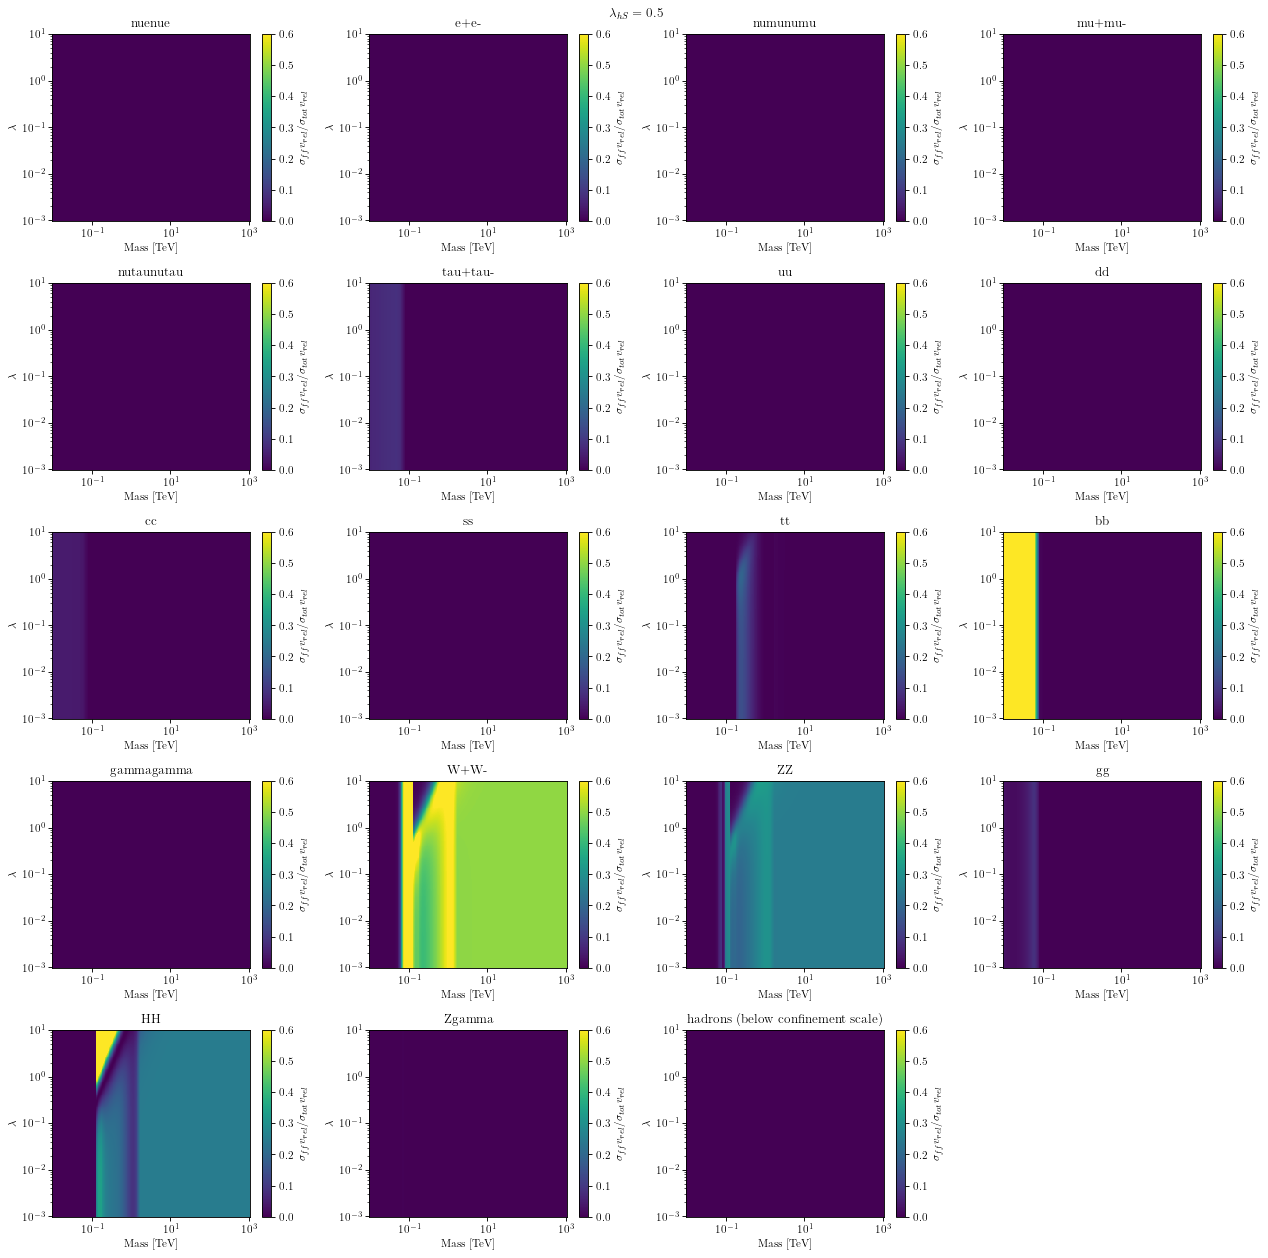

In [6]:
plt.figure(figsize=(16,16), dpi=80)
plt.suptitle(r"$\lambda_{hS}=0.5$")
massesabove0p1TeV = massvalues[massvalues>0.1]
for idx, channel_name in enumerate(list(df.columns)[2:]):
    plt.subplot(5,4, idx+1)
    plt.title(f"{channel_name}")
    plt.pcolormesh(massvalues, lambdavalues, 
                   (df.to_numpy()[:,idx+2]/np.sum(df.to_numpy()[:,2:],axis=1)).reshape(lambdavalues.shape[0], massvalues.shape[0]), vmin=0, vmax=0.6)#,
                #    norm=LogNorm(vmin=1e-50))
    plt.xlabel('Mass [TeV]')
    plt.ylabel('$\lambda$')
    plt.loglog()
    plt.colorbar(label=r'$\sigma_{ff} v_{rel}/\sigma_{tot} v_{rel}$')
plt.tight_layout()
plt.savefig('Figures/DM_Annihilation_Ratios_meshplots.pdf')
plt.show()

We can see that there are 4 'main' channels, the 'bb' channel for lower masses, then the 'W+W-', 'HH', and 'ZZ' channels for mass above ~0.08 TeV as we would want.


Now let's store these in a more user-friendly data structure, a dictionary where all the keys are the names of the channels as they are in darkSUSY and the values being functions that take in mass and coupling inputs and return the differential cross-section

In [7]:
import sys
from gammapy.astro.darkmatter import (
    profiles,
    JFactory
)
from astropy import units as u
from astropy.coordinates import SkyCoord
from gammapy.maps import Map, MapAxis, MapAxes, WcsGeom


from gammabayes.utils.event_axes import log10eaxistrue, longitudeaxistrue, latitudeaxistrue, makelogjacob
logjacob_true = np.meshgrid(makelogjacob(log10eaxis=log10eaxistrue), longitudeaxistrue, latitudeaxistrue, indexing='ij')[0]


partial_sigmav_interpolator_dictionary = {channel: interpolate.LinearNDInterpolator((df.to_numpy()[:,0]/1000, df.to_numpy()[:,1]),df.to_numpy()[:,idx+2]) for idx, channel in enumerate(list(df.columns)[2:])}
print(partial_sigmav_interpolator_dictionary)

/Users/lpin0002/anaconda3/envs/testywesty/lib/python3.11/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


{'nuenue': <scipy.interpolate.interpnd.LinearNDInterpolator object at 0x152d2b790>, 'e+e-': <scipy.interpolate.interpnd.LinearNDInterpolator object at 0x1565eb610>, 'numunumu': <scipy.interpolate.interpnd.LinearNDInterpolator object at 0x1584fc1d0>, 'mu+mu-': <scipy.interpolate.interpnd.LinearNDInterpolator object at 0x1584fc810>, 'nutaunutau': <scipy.interpolate.interpnd.LinearNDInterpolator object at 0x157f78d50>, 'tau+tau-': <scipy.interpolate.interpnd.LinearNDInterpolator object at 0x15542a3d0>, 'uu': <scipy.interpolate.interpnd.LinearNDInterpolator object at 0x158322550>, 'dd': <scipy.interpolate.interpnd.LinearNDInterpolator object at 0x158324190>, 'cc': <scipy.interpolate.interpnd.LinearNDInterpolator object at 0x15851dd90>, 'ss': <scipy.interpolate.interpnd.LinearNDInterpolator object at 0x1583f5c10>, 'tt': <scipy.interpolate.interpnd.LinearNDInterpolator object at 0x15852c6d0>, 'bb': <scipy.interpolate.interpnd.LinearNDInterpolator object at 0x158500190>, 'gammagamma': <scipy.

Let's test this out for a range of masses and a coupling value of 0.1 and dividing by the total cross-sections (for every mass) to get the branching fractions. 

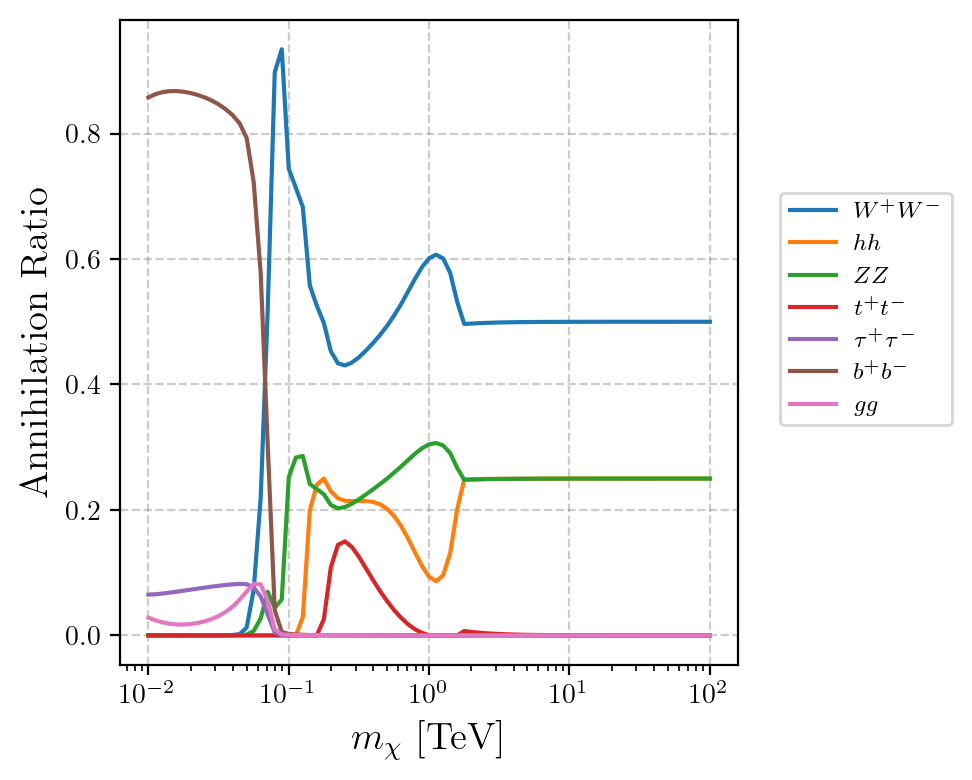

In [8]:

sigmavalues_dict = {}
testmassvalues = np.logspace(-2,2,81)
plt.figure(dpi=200, figsize=(5,4))

total_cross_sections = 0
for channel, sigmavfunc in partial_sigmav_interpolator_dictionary.items():
    total_cross_sections += sigmavfunc(testmassvalues, 0.1)
    sigmavalues_dict[channel] = sigmavfunc(testmassvalues, 0.1)
    

plt.plot(testmassvalues, sigmavalues_dict['W+W-']/total_cross_sections, label=r'$W^{+}W^{-}$')
plt.plot(testmassvalues, sigmavalues_dict['HH']/total_cross_sections, label=r'$hh$')
plt.plot(testmassvalues, sigmavalues_dict['ZZ']/total_cross_sections, label=r'$ZZ$')
plt.plot(testmassvalues, sigmavalues_dict['tt']/total_cross_sections, label=r'$t^+t^-$')

plt.plot(testmassvalues, sigmavalues_dict['tau+tau-']/total_cross_sections, label=r'$\tau^+\tau^-$')
plt.plot(testmassvalues, sigmavalues_dict['bb']/total_cross_sections, label=r'$b^+b^-$')
plt.plot(testmassvalues, sigmavalues_dict['gg']/total_cross_sections, label=r'$gg$')


plt.ylabel('Annihilation Ratio', size=14)
plt.xlabel(r'$m_\chi$ [TeV]', size=14)

plt.grid(axis='both', alpha=0.4, c='grey', ls='--')


plt.xscale('log')
plt.legend(bbox_to_anchor=(1.05, 0.75), fontsize='small')
plt.tight_layout()
plt.savefig("Figures/SS_DM_BFs.pdf")
plt.show()

    


Let's also store all the names of the channels as they are in darkSUSY and in Gammapy/PPPC tables.

In [9]:
darkSUSY_to_Gammapy_converter = {
    "nuenue":"nu_e",
    "e+e-": "e",
    "numunumu":"nu_mu",
    "mu+mu-":"mu",
    'nutaunutau':"nu_tau",
    "tau+tau-":"tau",
    "cc": "c",
    "bb": "b",
    "tt": "t",
    "W+W-": "W",
    "ZZ": "Z",
    "gg": "g",
    "gammagamma": "gamma",
    "HH": "h",
}

## Total Z_2 scalar singlet dark matter spectra

Once we have the fraction every final state to get the total dark matter spectra we need the spectra for each channel. The values for the individual flux of every channel are stored within the `griddata` folder of the package along with the mass and log10x values that created them. 

If a channel exists in darkSUSY but not these tables then we simply say that the spectral flux will be 0 with a lambda function.

In [10]:
channelfuncdictionary = {}
modulefolderpath = resource_dir+'/../dark_matter/'
massvalues          = np.load(modulefolderpath+f"/griddata/massvals_massenergy_diffflux_grid.npy")/1e3
log10xvals        = np.load(modulefolderpath+f"/griddata/log10xvals_massenergy_diffflux_grid.npy")

for darkSUSYchannel in df.columns[2:]:
    try:
        gammapychannel = darkSUSY_to_Gammapy_converter[darkSUSYchannel]
        tempspectragrid = np.load(modulefolderpath+f"/griddata/channel={gammapychannel}_massenergy_diffflux_grid.npy")
        channelfuncdictionary[darkSUSYchannel] = interpolate.interp2d(np.log10(massvalues), log10xvals, np.array(tempspectragrid).T, 
                                    kind='linear', bounds_error=False, fill_value=1e-3000)
    except:
        channelfuncdictionary[darkSUSYchannel] = lambda logmass, log10x: log10x*0

/var/folders/xr/793vfd394l701z7tfh27tbj9q0x4gd/T/ipykernel_58553/3600470599.py:10: DeprecationWarning: `interp2d` is deprecated!
`interp2d` is deprecated in SciPy 1.10 and will be removed in SciPy 1.12.0.

For legacy code, nearly bug-for-bug compatible replacements are
`RectBivariateSpline` on regular grids, and `bisplrep`/`bisplev` for
scattered 2D data.

In new code, for regular grids use `RegularGridInterpolator` instead.
For scattered data, prefer `LinearNDInterpolator` or
`CloughTocher2DInterpolator`.

For more details see
`https://gist.github.com/ev-br/8544371b40f414b7eaf3fe6217209bff`

  channelfuncdictionary[darkSUSYchannel] = interpolate.interp2d(np.log10(massvalues), log10xvals, np.array(tempspectragrid).T,


Let's make a handy function to combine the differential cross-sections and the single channel spectra.

In [11]:
from scipy.special import logsumexp


def construct_spectra(massval, channelfuncdictionary=channelfuncdictionary, partial_sigmav_interpolator_dictionary=partial_sigmav_interpolator_dictionary):
    
    partial_SS_spectra = []
    for channel in darkSUSY_to_Gammapy_converter.keys():
        partial_SS_spectra.append(np.log(float(partial_sigmav_interpolator_dictionary[channel](massval, 0.1)))\
                        +np.log(channelfuncdictionary[channel](np.log10(massval), log10eaxistrue-np.log10(massval))))
    SS_spectra = logsumexp(partial_SS_spectra, axis=0)

    return SS_spectra


Testing this function out we find.

/var/folders/xr/793vfd394l701z7tfh27tbj9q0x4gd/T/ipykernel_58553/1157802768.py:9: DeprecationWarning:         `interp2d` is deprecated!
        `interp2d` is deprecated in SciPy 1.10 and will be removed in SciPy 1.12.0.

        For legacy code, nearly bug-for-bug compatible replacements are
        `RectBivariateSpline` on regular grids, and `bisplrep`/`bisplev` for
        scattered 2D data.

        In new code, for regular grids use `RegularGridInterpolator` instead.
        For scattered data, prefer `LinearNDInterpolator` or
        `CloughTocher2DInterpolator`.

        For more details see
        `https://gist.github.com/ev-br/8544371b40f414b7eaf3fe6217209bff`

  +np.log(channelfuncdictionary[channel](np.log10(massval), log10eaxistrue-np.log10(massval))))


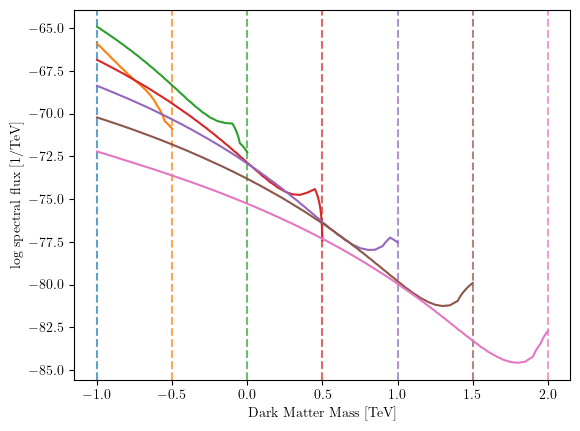

In [12]:
massval_list = np.logspace(-1,2,7)

plt.figure()
for massval in massval_list:
    plotstuff = plt.plot(log10eaxistrue,construct_spectra(massval)) 
    plt.axvline(np.log10(massval), c=plotstuff[0].get_color(), ls='--', alpha=0.7)
plt.xlabel('Dark Matter Mass [TeV]')
plt.ylabel('log spectral flux [1/TeV]')
plt.show()

## Differential J factors

The CTA will also collect sky position data, so we need an angular distribution for the dark matter. For this we will use the differential J factors for a dark matter density profile. For the reason why we use the differential J factors please read the release paper for the code. 

For now we will use the Einasto dark matter density profile and using `Gammapy` to calculate the differential J factors. For further detail on how this calculation works please head over to the Gammapy documentation found [here](https://docs.gammapy.org/dev/api/gammapy.astro.darkmatter.JFactory.html).

In [13]:
from gammabayes.utils.utils import convertlonlat_to_offset
from gammabayes.likelihoods.instrument_response_funcs import log_aeff

profile = profiles.EinastoProfile()

# Adopt standard values used in HESS
profiles.DMProfile.DISTANCE_GC = 8.5 * u.kpc
profiles.DMProfile.LOCAL_DENSITY = 0.39 * u.Unit("GeV / cm3")

profile.scale_to_local_density()

position = SkyCoord(0.0, 0.0, frame="galactic", unit="deg")
geom = WcsGeom.create(skydir=position, 
                      binsz=longitudeaxistrue[1]-longitudeaxistrue[0],
                      width=(longitudeaxistrue[-1]-longitudeaxistrue[0]+longitudeaxistrue[1]-longitudeaxistrue[0], latitudeaxistrue[-1]-latitudeaxistrue[0]+longitudeaxistrue[1]-longitudeaxistrue[0]),
                      frame="galactic")


jfactory = JFactory(
    geom=geom, profile=profile, distance=profiles.DMProfile.DISTANCE_GC
)

We convert the differential J factor to 'TeV^2/(m^5 sr)', extract the unit and then store the values in `diff_j_factors_values`.

In [14]:
diff_j_factors = jfactory.compute_differential_jfactor().to(u.Unit('TeV^2/(m^5 sr)'))
diff_j_factors_unit = diff_j_factors.unit
diff_j_factors_values = diff_j_factors.value

Let's have a look at these factors.

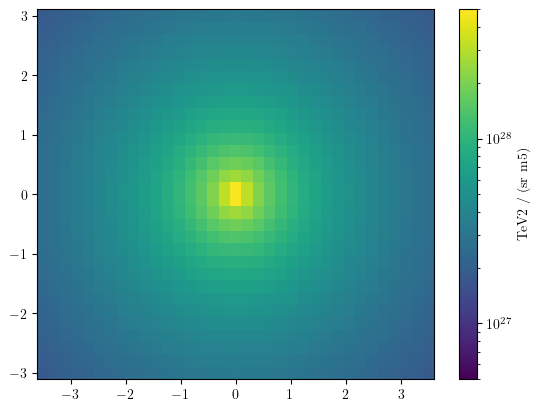

In [15]:
plt.figure()
plt.pcolormesh(longitudeaxistrue, latitudeaxistrue, diff_j_factors_values, norm=LogNorm(vmin=5e26, vmax=5e28))
plt.colorbar(label=diff_j_factors_unit)
plt.show()

## Effective Area

Okay so we have the energy distribution and angular distribution...but the tutorial is still going? We remind the reader that we have not accounted for what the __CTA__ will observe, as aspects of the telescope will mean that some fluxes are less likely to be seen while others are more likely to be detected.

This is contained within the effective area of the telescope. `GammaBayes` has a useful wrapper of the function as it appears in `Gammapy` that outputs the log of the effective area instead of the straight effective area to minimise computational instability problems for later analysis.

Let's construct a grid of values as we did for the differential J factors and look a slice of the result although if you've already looked at the astrophysical background tutorial it should look very familiar.

In [16]:
log10eaxistrue_mesh, longitudeaxistrue_mesh, latitudeaxistrue_mesh = np.meshgrid(log10eaxistrue, longitudeaxistrue, latitudeaxistrue, indexing='ij')

log_aeff_vals = log_aeff(log10eaxistrue_mesh.flatten(), longitudeaxistrue_mesh.flatten(), latitudeaxistrue_mesh.flatten()).reshape(log10eaxistrue_mesh.shape)
log_aeff_vals.shape

(601, 35, 30)

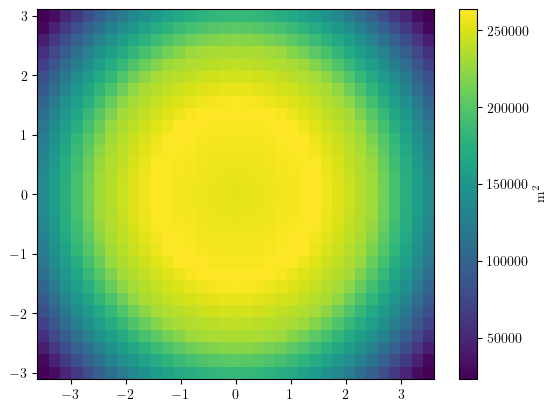

In [17]:
plt.figure()
plt.pcolormesh(longitudeaxistrue, latitudeaxistrue, np.exp((log_aeff_vals+logjacob_true)[150,:,:].T))
plt.colorbar(label=r'm$^2$')
plt.show()

## The full picture

We then combine all these by mutliplying them all together, or rather add them because they are (will be ) in log-space.

In [18]:
# For a mass of 10 TeV
full_SS_prior_grid = log_aeff_vals+construct_spectra(10.0)[:,:, np.newaxis]+np.log(diff_j_factors_values.T[np.newaxis, :,:])

/var/folders/xr/793vfd394l701z7tfh27tbj9q0x4gd/T/ipykernel_58553/1157802768.py:9: DeprecationWarning:         `interp2d` is deprecated!
        `interp2d` is deprecated in SciPy 1.10 and will be removed in SciPy 1.12.0.

        For legacy code, nearly bug-for-bug compatible replacements are
        `RectBivariateSpline` on regular grids, and `bisplrep`/`bisplev` for
        scattered 2D data.

        In new code, for regular grids use `RegularGridInterpolator` instead.
        For scattered data, prefer `LinearNDInterpolator` or
        `CloughTocher2DInterpolator`.

        For more details see
        `https://gist.github.com/ev-br/8544371b40f414b7eaf3fe6217209bff`

  +np.log(channelfuncdictionary[channel](np.log10(massval), log10eaxistrue-np.log10(massval))))


Now let's look at the full model.

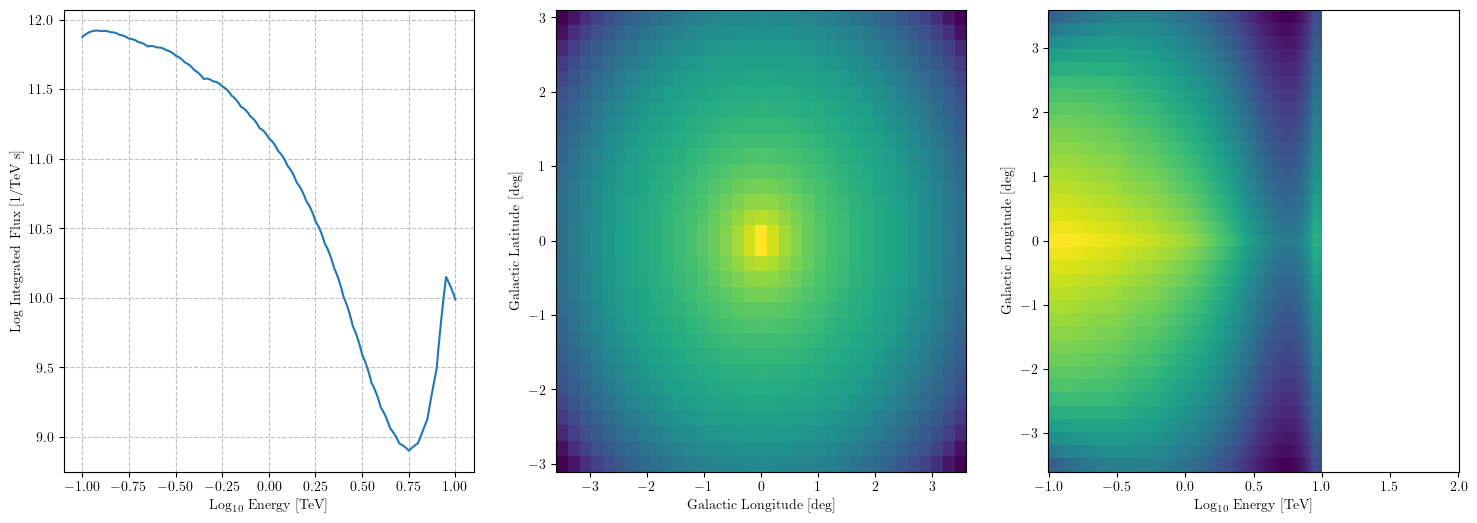

In [19]:
plt.figure(figsize=(18,6))
plt.subplot(131)
plt.plot(log10eaxistrue, logsumexp(full_SS_prior_grid+logjacob_true, axis=(1,2)))
plt.xlabel(r'Log$_{10}$ Energy [TeV]')
plt.grid(True, which='both', ls='--', alpha=0.8)
plt.ylabel('Log Integrated Flux [1/TeV s]')

plt.subplot(132)
plt.pcolormesh(longitudeaxistrue, latitudeaxistrue, logsumexp(full_SS_prior_grid+logjacob_true, axis=0).T)
plt.xlabel('Galactic Longitude [deg]')
plt.ylabel('Galactic Latitude [deg]')


plt.subplot(133)
plt.pcolormesh(log10eaxistrue, longitudeaxistrue, logsumexp(full_SS_prior_grid+logjacob_true, axis=2).T,)
plt.ylabel('Galactic Longitude [deg]')
plt.xlabel(r'Log$_{10}$ Energy [TeV]')
plt.show()


## Using GammaBayes

In `GammaBayes` all this is taken care of with the `SS_DM_dist` module which is typically used as follows.

In [21]:
from gammabayes.dark_matter.SS_DM_Constructor import SS_DM_dist

dm_dist_constructor = SS_DM_dist(longitudeaxis=longitudeaxistrue, latitudeaxis=latitudeaxistrue)
dm_dist_constructor_logfunc = dm_dist_constructor.func_setup() # Creates a function that returns the log of the flux of the full model

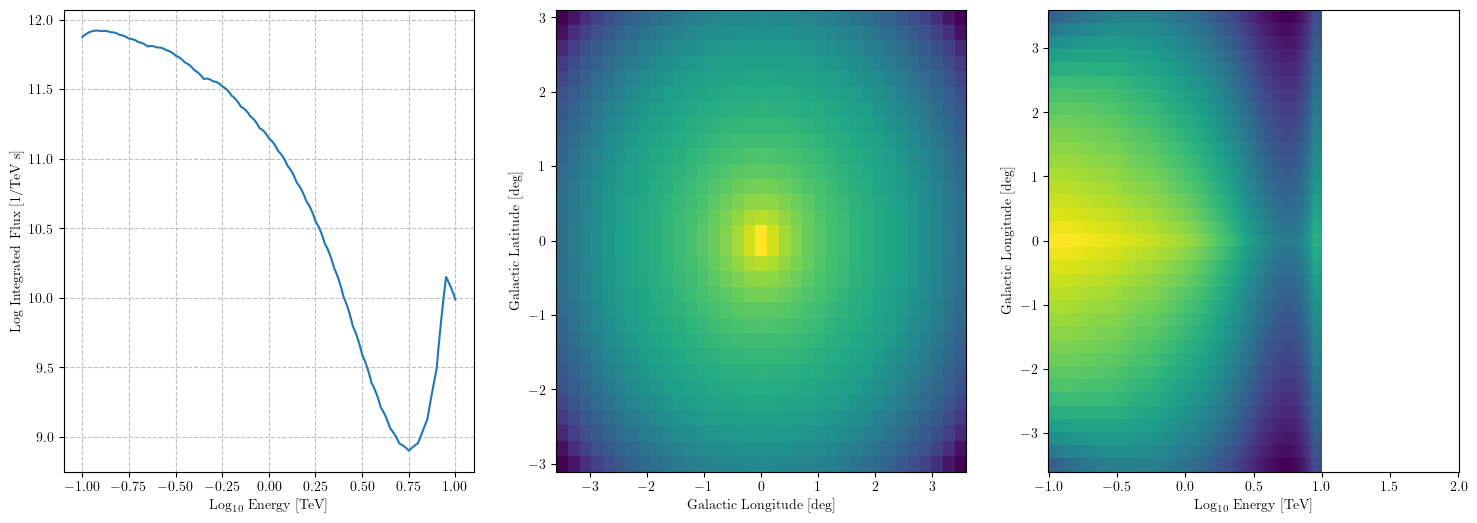

In [22]:

#                                                                                                                       For a mass of 10 TeV
logflux_constructor_vers = dm_dist_constructor_logfunc(log10eaxistrue_mesh, longitudeaxistrue_mesh, latitudeaxistrue_mesh, np.log10(10))

plt.figure(figsize=(18,6))
plt.subplot(131)
plt.plot(log10eaxistrue, logsumexp(full_SS_prior_grid+logjacob_true, axis=(1,2)))
plt.xlabel(r'Log$_{10}$ Energy [TeV]')
plt.grid(True, which='both', ls='--', alpha=0.8)
plt.ylabel('Log Integrated Flux [1/TeV s]')

plt.subplot(132)
plt.pcolormesh(longitudeaxistrue, latitudeaxistrue, logsumexp(full_SS_prior_grid+logjacob_true, axis=0).T)
plt.xlabel('Galactic Longitude [deg]')
plt.ylabel('Galactic Latitude [deg]')


plt.subplot(133)
plt.pcolormesh(log10eaxistrue, longitudeaxistrue, logsumexp(full_SS_prior_grid+logjacob_true, axis=2).T,)
plt.ylabel('Galactic Longitude [deg]')
plt.xlabel(r'Log$_{10}$ Energy [TeV]')
plt.show()